In [1]:
import xlrd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
# 按行打印字典
def printDict(dictionary):
    for item in dictionary.items():
        print(item)
        
# 按行打印列表
def printList(mylist):
    for index, value in enumerate(mylist):
        print(str(index) + " " + str(value))
                
# 反转字典的key和value
def reverseDict(dictionary):
    res = {}
    for key in dictionary.keys():
        value = dictionary[key]
        res[value] = key
    return res

In [3]:
# 根据词典对train data进行编码
# INPUT:
#  dictionary: {word: index}
#  wordList: ['窑尾', '排风机', '风机', '轴承']
#  length: 结果向量的最大长度
#
# OUTPUT:
#  [1.0, 3.0, 10.0, 11.0, 0.0, 0.0, 0.0]
def encodeWord(dictionary, wordList, length):
    resArray = np.zeros(length)
    for index, word in enumerate(wordList):
        if(word in dictionary):
            wordIndex = dictionary[word]
            resArray[index] = wordIndex
        else:
            resArray[index] = 1
    return resArray.tolist()

# 根据词典批量编码文本
def batchEncodeWord(dictionary, wordCol, length):
    res = []
    for cell in wordSplitCol:
        wordList = cell.value.split("-")
        wordEncodeList = encodeWord(wordDict, wordList, length)
        res.append(wordEncodeList)
    return res

# 根据excel文件创建字典列表
def createDict(wordSplitCol):
    res = {}
    
    # index 0: 保留索引，用于表示广播项
    # index 1: 保留索引，用于表示不在辞典中的词
    res["padding"] = 0
    res["?"] = 1
    
    index = 2
    for cell in wordSplitCol:
        wordList = cell.value.split("-")
        for word in wordList:
            if((word in res) == False):
                res[word] = index
                index += 1
    return res

In [4]:
# 根据词典批量编码label
def batchEncodeLabel(dictionary, wordCol, length):
    res = []
    for cell in wordCol:
        label = cell.value
        labelIndex = dictionary[label]
        res.append(labelIndex)
    return res

# 根据excel文件创建字典列表
def createLabelDict(wordSplitCol):
    res = {}
    index = 0
    for cell in wordSplitCol:
        word = cell.value
        if((word in res) == False):
            res[word] = index
            index += 1
    return res

In [5]:
data = xlrd.open_workbook("samples/tagSamples.xls")
table = data[1]

In [6]:
rawTagNameCol = table.col(0, start_rowx=0, end_rowx=None)
systemLabelCol = table.col(1, start_rowx=0, end_rowx=None)
wordSplitCol = table.col(2, start_rowx=0, end_rowx=None)

## Create train data

In [7]:
# 创建词典{word: index}
wordDict = createDict(wordSplitCol)
#printDict(wordDict)

# 创建翻转词典{index: word}
wordDictReverse = reverseDict(wordDict)

# 将文本分词
#wordList = wordSplitCol[14].value.split("-")

# 将分词后的文本转化为向量表示
#wordEncodeList = encodeWord(wordDict, wordList, 7)

# 将输入文本根据字典编码
wordEncodeList = batchEncodeWord(wordDict, wordSplitCol, 5)
#printList(wordEncodeList)

## Creat label data

In [8]:
# 创建词典{word: index}
labelDict = createLabelDict(systemLabelCol)
#printDict(labelDict)

# 创建翻转词典{index: word}
labelDictRe = reverseDict(labelDict)
#printDict(labelDictRe)

# 将输入文本根据字典编码
labelEncodeList = batchEncodeLabel(labelDict, systemLabelCol, 1)

In [9]:
print("分类数量: " + str(len(labelDict)))
print("样本数量: " + str(len(wordEncodeList)) + " 样本维度: " + str(len(wordEncodeList[0])))
print("字典大小: " + str(len(wordDict.keys())))

分类数量: 26
样本数量: 2794 样本维度: 5
字典大小: 702


## Trans to array

In [10]:
def oneHot(dictionary, encodeData):
    res = []
    length = len(dictionary.keys())
    dictionaryRe = reverseDict(dictionary)
    for data in encodeData:
        dataArray = np.zeros(length)
        for item in data:
            dataArray[int(item)] = 1
        dataOneHot = dataArray.tolist()
        res.append(dataOneHot)
    return res

In [11]:
# oneHot编码label和train数据
yData = np.asarray(labelEncodeList)
yDataOneHot = to_categorical(yData)

xDataOneHot = oneHot(wordDict, wordEncodeList)
xDataOneHot = np.asarray(xDataOneHot)

#print(xDataOneHot.shape)
#print(yDataOneHot.shape)

## Ready Train Data

In [12]:
# 创建验证集
def createValData(random, dataArray):
    val = []
    train = []
    for seed in random:
        val.append(dataArray[seed])
    
    train = np.delete(dataArray, random, axis = 0)
            
    return np.array(val), train

In [13]:
# 生成验证集的随机种子
randomSeed = np.random.choice(2000, size=300, replace=False)

xVal, xTrain = createValData(randomSeed, xDataOneHot)
yVal, yTrain = createValData(randomSeed, yDataOneHot)

In [14]:
print("Val data size：" + str(xVal.shape[0]))
print("Val label size：" + str(yVal.shape[0]))

print("Train data size：" + str(xTrain.shape[0]))
print("Train label size：" + str(yTrain.shape[0]))

Val data size：300
Val label size：300
Train data size：2494
Train label size：2494


In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(702,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=300,
                    validation_data=(xVal, yVal))

Epoch 1/20
9/9 [==============================] - 0s 29ms/step - loss: 3.1789 - accuracy: 0.1725 - val_loss: 3.0208 - val_accuracy: 0.2167
Epoch 2/20
9/9 [==============================] - 0s 3ms/step - loss: 2.9504 - accuracy: 0.2381 - val_loss: 2.7662 - val_accuracy: 0.2300
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 2.6929 - accuracy: 0.2367 - val_loss: 2.5228 - val_accuracy: 0.2433
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 2.4687 - accuracy: 0.2709 - val_loss: 2.3583 - val_accuracy: 0.3200
Epoch 5/20
9/9 [==============================] - 0s 3ms/step - loss: 2.2809 - accuracy: 0.3702 - val_loss: 2.2241 - val_accuracy: 0.3867
Epoch 6/20
9/9 [==============================] - 0s 3ms/step - loss: 2.1318 - accuracy: 0.4385 - val_loss: 2.0899 - val_accuracy: 0.4400
Epoch 7/20
9/9 [==============================] - 0s 3ms/step - loss: 2.0090 - accuracy: 0.4861 - val_loss: 1.9610 - val_accuracy: 0.4867
Epoch 8/20
9/9 [=================

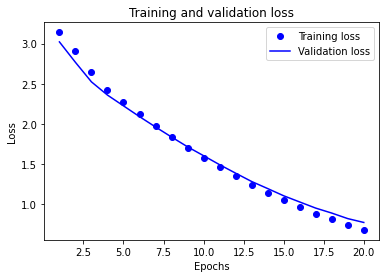

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Predict

In [18]:
inputVec = xTrain[:1]
predictions = model.predict(xTrain[:1])
res = predictions[0].tolist()
maxIndex = res.index(max(res))

In [19]:
# tagDesc = "窑尾-排风机-出口"
def predict(dictionary, dictionaryLabel, tagName, model):
    
    # 根据词典编码
    encodeData = []
    tagNameSplit = tagName.split("-")
    tagNameEncode = encodeWord(dictionary, tagNameSplit, 5)
    encodeData.append(tagNameEncode)
    
    # oneCode向量化
    tagOneCode = np.array(oneHot(dictionary, encodeData))
    
    # 预测
    predictions = model.predict(tagOneCode[:1])
    res = predictions[0].tolist()
    maxIndex = res.index(max(res))
    probility = res[maxIndex]
    
    # 解析预测结果
    dictionaryLabelRe = reverseDict(dictionaryLabel)
    print("预测所属系统：" + str(dictionaryLabelRe[maxIndex]) + " 预测概率：" + format(probility*100, '.2f') + "%")

In [20]:
tag = "窑尾-除尘器"
predict(wordDict, labelDict, tag, model)

预测所属系统：3-4 预测概率：30.33%


In [21]:
a = 1
b = 3

In [22]:
c = a + b
print(c)

4
